In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [3]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [5]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')
# lsbg_cat['image_flag'] = np.ones(len(lsbg_cat), dtype=bool)
# lsbg_cat['psf_flag'] = np.ones(len(lsbg_cat), dtype=bool)
print('# of LSBGs:', len(lsbg_cat))
channels = 'griz'

# of LSBGs: 5000


In [6]:
np.sum(~np.all(lsbg_cat['image_flag'], axis=1))

81

In [7]:
lsbg = lsbg_cat[2600] # 12 # 69

In [8]:
lsbg

<Row index=2600>
viz-id         ra                  dec              mag_auto_i         sersic_n         sersic_ell         sersic_PA     sersic_rhalf_circ                sersic_sed                                mags                              prefix              image_flag    psf_flag  
int64       float64              float64             float64           float64           float64            float64           float64                     float64[4]                             float64[4]                          bytes65               bool[4]      bool[4]   
------ ------------------ --------------------- ----------------- ----------------- ------------------ ----------------- ----------------- --------------------------------------- -------------------------------------- ------------------------------ ------------ ------------
  2600 222.98625970560892 -0.028949220336171328 19.37962126533876 1.013392083497913 0.0115037464499389 45.82749574040261 3.835906063850943 0.6511502140420645 .. 1.033814360511353 19.84541829620627 .. 19.34351486390738 ./Cutout/mock_sample/mock_2600 True .. True True .. True

In [9]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [10]:
fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
                       starlet_thresh=0.3, min_grad=-0.2,
                       monotonic=True, bkg=True,
                       variance=0.015**2, 
                       scales=[0, 1, 2],# , 3, 4
                       model_dir='./Model/mock_sample/',
                       figure_dir='./Figure/mock_sample',
                       log_dir='./log/mock_sample',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

  - Detect sources and make mask
    Query GAIA stars...


    Taking Gaia catalogs stored in `Tigress`
    9 stars from Gaia are masked!
    Detected 271 objects
    9 stars from Gaia are masked!
    Detected 190 objects
    Detected 92 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.20, starlet_thresh = 0.30 (contam_ratio = 0.11), 
     monotonic = True, variance = 0.00022, scales = [0, 1, 2].
    Added constant sky background
    Total number of sources: 18
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 43 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 63 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 83 iterations! Try higher accuracy!
  - After 77 iterations, logL = 2388156.39
    Elapsed time for fitting: 65.29 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuan

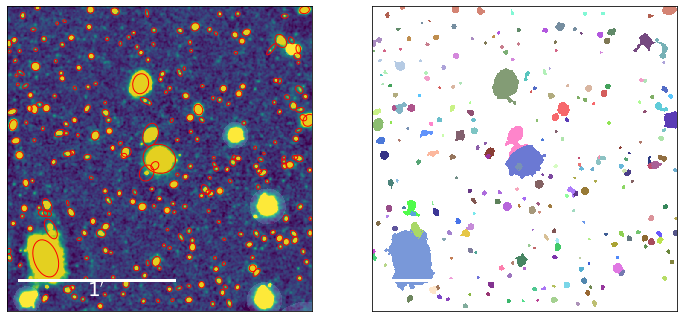

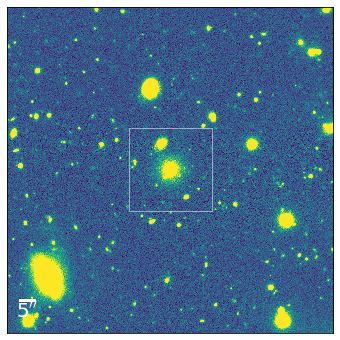

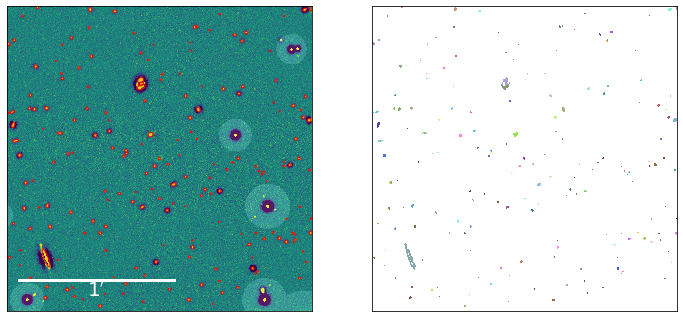

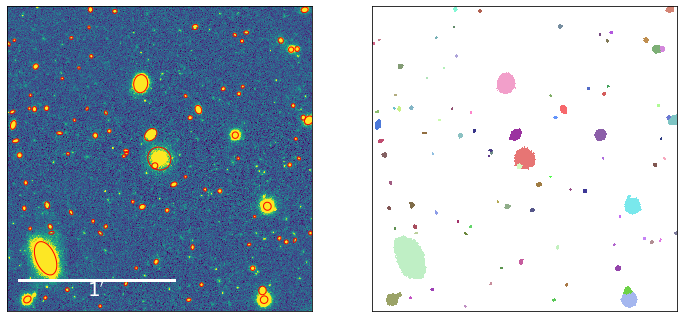

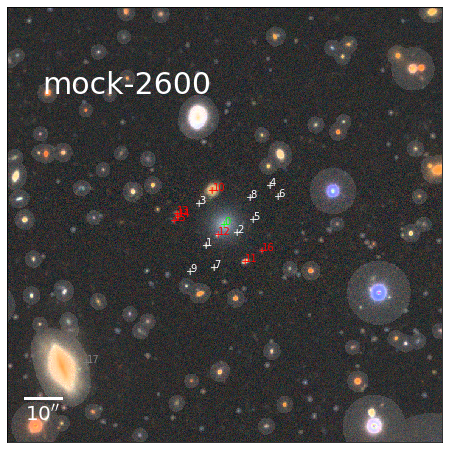

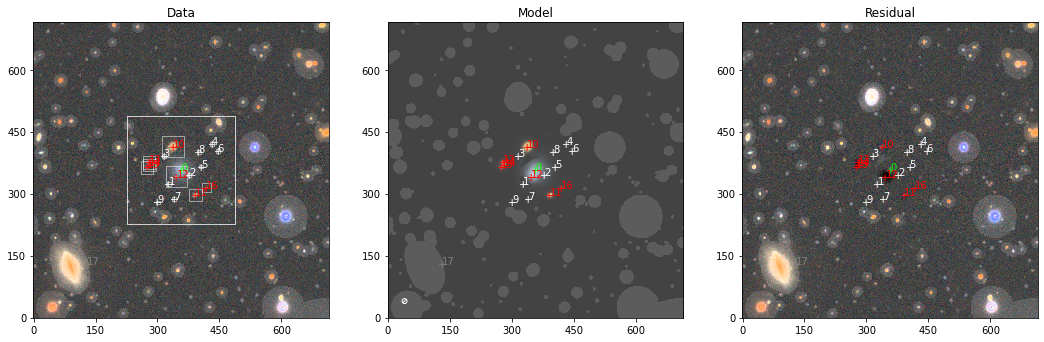

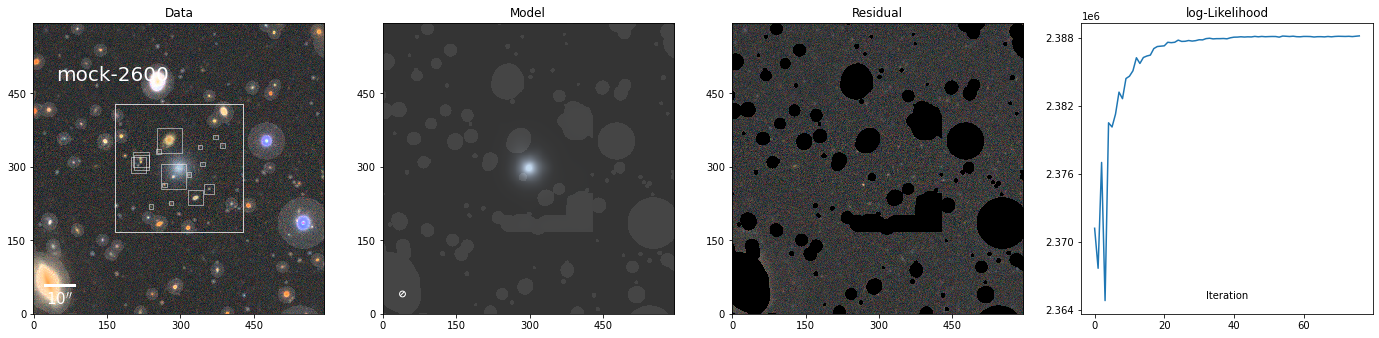

In [11]:
fitter.fit()

#### Step-by-step

In [151]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    8 stars from Gaia are masked!


In [152]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 278 objects


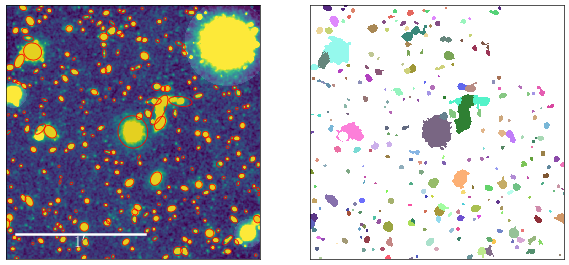

In [153]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont)

In [154]:
import scarlet.initialization as init

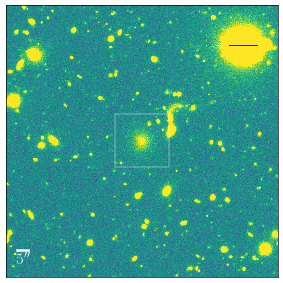

In [155]:
fitter._estimate_box(fitter.cen_obj)

In [156]:
fitter._mask_stars_outside_box()

    8 stars from Gaia are masked!


    Detected 228 objects


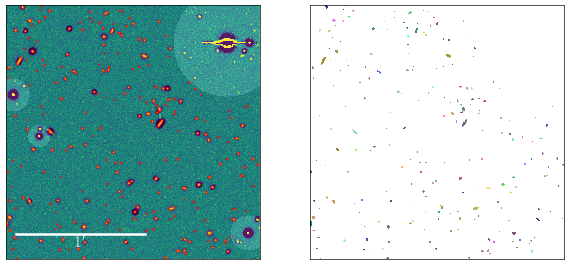

In [157]:
fitter._cpct_obj_detection()

In [158]:
from kuaizi.display import draw_circles

    Detected 141 objects


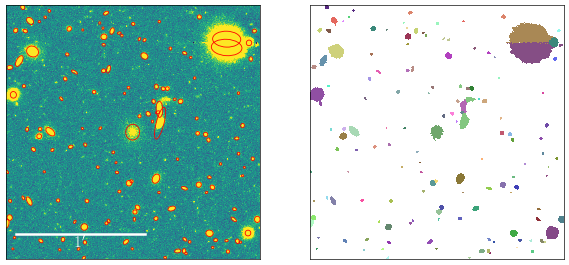

In [159]:
fitter._big_obj_detection()

In [160]:
fitter._merge_catalogs()

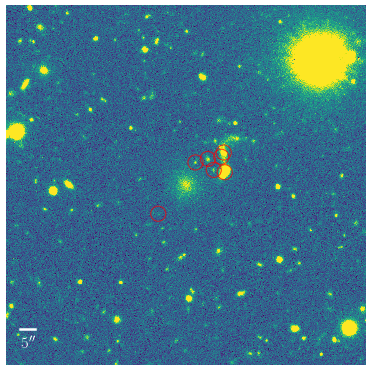

In [161]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [162]:
fitter._construct_obs_frames()

In [191]:
if fitter.bright:
    fitter.variance = 0.05**2
    fitter.scales = [0, 1, 2, 3, 4, 5, 6]
    fitter.starlet_thresh = 0.5
    fitter.min_grad = 0.01

fitter.variance=0.01**2
# fitter._add_sources(min_grad=fitter.min_grad, thresh=0.1)
fitter._add_sources(min_grad=-0.2, thresh=0.1)

  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.20, starlet_thresh = 0.30 (contam_ratio = 0.12), 
     monotonic = True, variance = 0.00010, scales = [0, 1, 2, 3, 4].
    Added constant sky background
    Total number of sources: 9


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

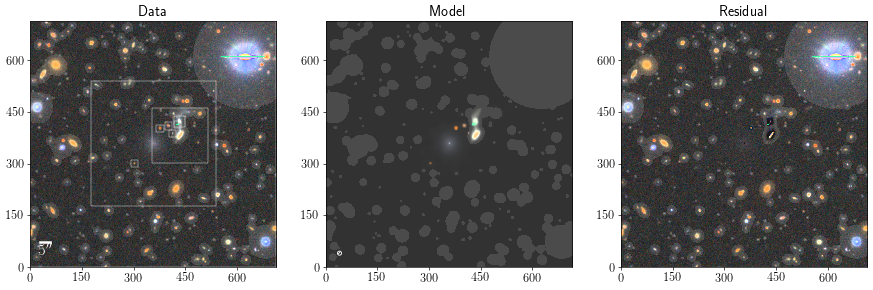

In [192]:
kz.display.display_scarlet_model(
    fitter.blend,
    #show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

In [165]:
# fitter.blend.fit(10)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 113 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 179 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 245 iterations! Try higher accuracy!
  - After 207 iterations, logL = 2284283.69
    Elapsed time for fitting: 332.08 s


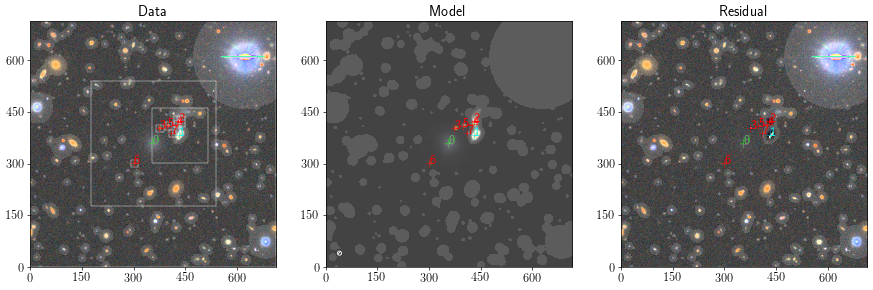

In [166]:
try:
    fitter._optimize()
#     fitter._optimize()
except:
    pass

In [167]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
except:
    pass

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-1498-trained-model-wavelet.df


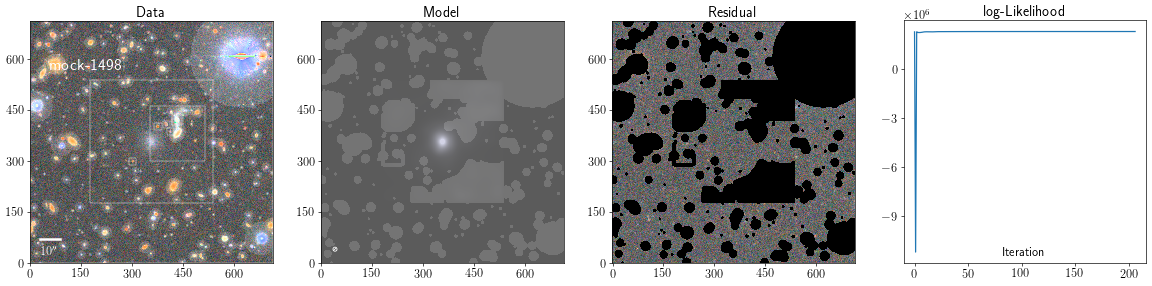

In [168]:
fitter._display_results(stretch=0.5)

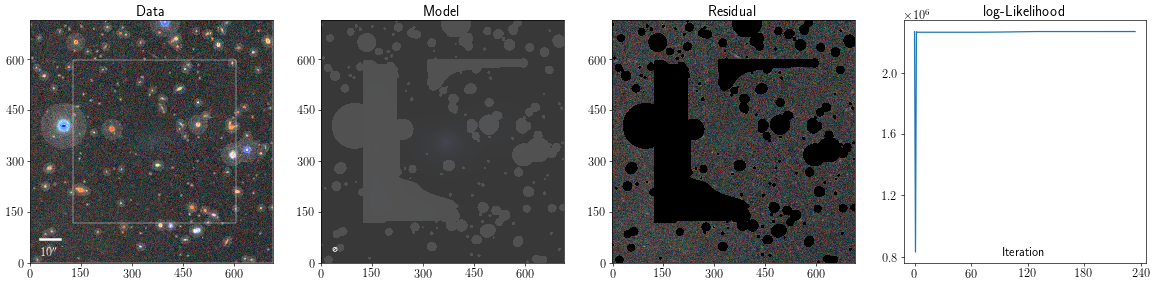

In [79]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
        fitter.final_mask,
        show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.8,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [21]:
morph = fitter.blend.sources[0].morphology

In [99]:
morph.shape

(8, 391, 391)

In [1396]:
from scarlet import Starlet

In [1397]:
s = Starlet.from_coefficients(morph)

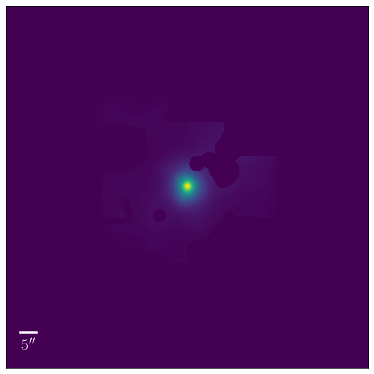

In [174]:
# display_single(s.image, scale='linear');
model = fitter.blend.get_model()
display_single(fitter.observation.render(model)[0] * (~fitter.final_mask), scale='linear');
# model.mean()

In [175]:
from scarlet.operator import prox_monotonic_mask

In [176]:
src = fitter.blend.sources[0]
morph = src.morphology
img = src.get_model()
img = fitter.observation.render(img)
center = tuple(s // 2 for s in src.bbox.shape[1:])

In [184]:
prox = prox_monotonic_mask(
    img[0], 1e-3, 
    center=center,
    zero=0,
            center_radius=2,
            variance=1e-5,
            max_iter=10)
print(prox[2])
print(np.sum(~prox[0]))

[  0 360   0 360]
43972


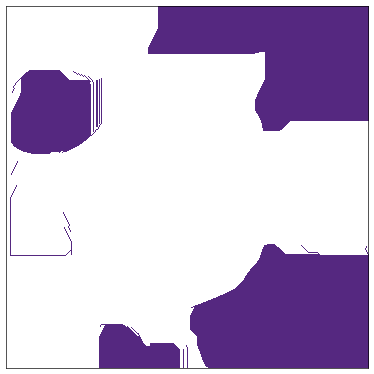

In [185]:
display_single((~prox[0]).astype(float), cmap=SEG_CMAP, scale='linear');

In [186]:
from astropy.convolution import convolve, Gaussian2DKernel

In [187]:
smooth_radius = 4
gaussian_threshold = 0.02
mask_conv = np.copy(~prox[0])
mask_conv = convolve(mask_conv.astype(
    float), Gaussian2DKernel(smooth_radius))
mask_conv = (mask_conv > gaussian_threshold)
monomask = np.zeros(fitter.blend.bbox.shape[1:])
monomask[src.bbox.origin[1]:src.bbox.origin[1] + src.bbox.shape[1],
         src.bbox.origin[2]:src.bbox.origin[2] + src.bbox.shape[2]] = mask_conv
monomask = monomask.astype(bool)

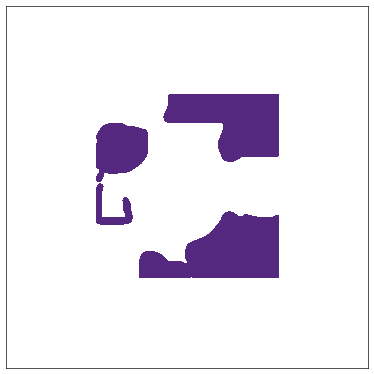

In [188]:
display_single(monomask.astype(float), cmap=SEG_CMAP, scale='linear');

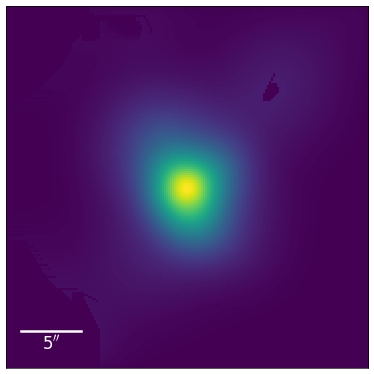

In [88]:
display_single((prox[1]).astype(float), scale='linear');

In [82]:
lsbg = lsbg_cat[62]

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

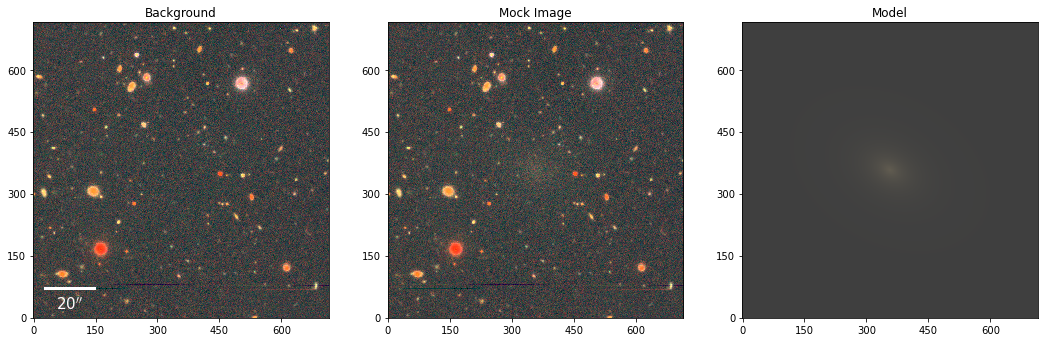

In [85]:
import pickle

with open(f'./Cutout/mock_sample/mock_{lsbg["viz-id"]}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [26]:
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

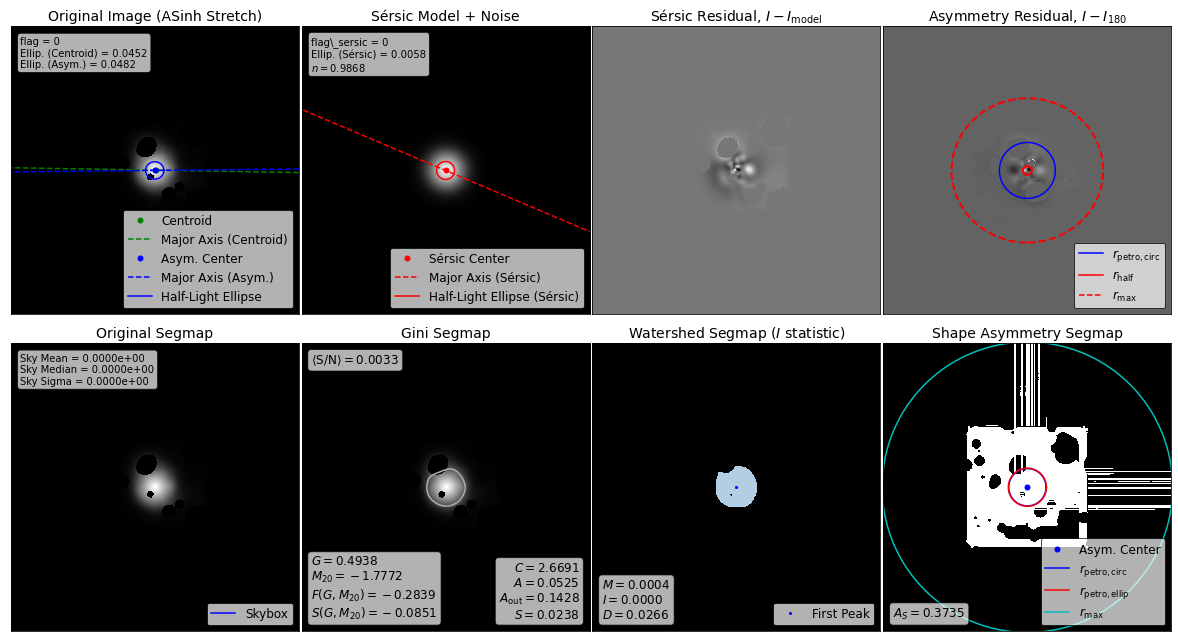

In [35]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 method='wavelet',
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [172]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([52.7905796 , 52.342842  , 52.42655924, 51.96584577])

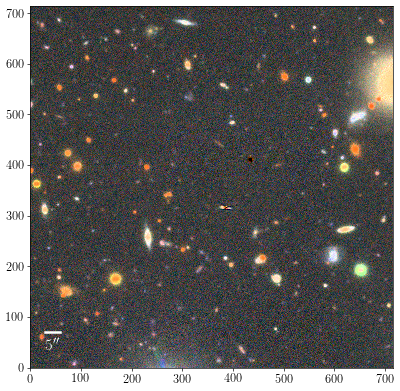

In [142]:
display_rgb(gal.mock.images - fitter.observation.render(fitter.blend.get_model()), stretch=0.8);

In [173]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

6.5178762752657615
4.556496604388463


5.766177080267909

In [144]:
measurement['SB_eff_avg'], measurement['mag']

(array([26.83955 , 26.336582, 26.23665 , 26.033377], dtype=float32),
 array([20.026892, 19.523926, 19.423992, 19.220718], dtype=float32))

In [145]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([20.185423, 19.682457, 19.582523, 19.37925 ], dtype=float32)

In [146]:
gal.model.info['gmag'], gal.model.info['rmag'], gal.model.info['imag']

(19.586801616575784, 19.105766375976312, 18.91499059787971)

In [106]:
measurement['ellipticity_asymmetry'], 1 - gal.model.info['comp'][0]['shear_params']['q']

(0.10488742520449135, 0.0756825948096912)

In [746]:
from matplotlib import colors
divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

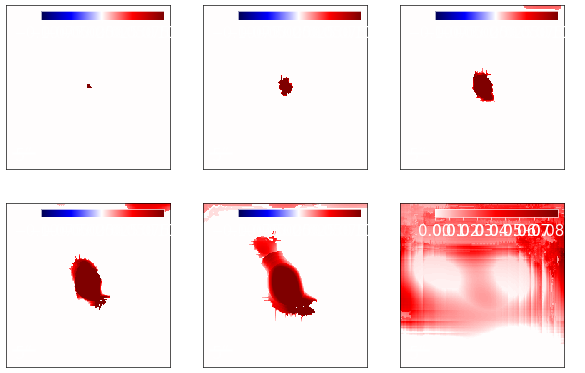

In [747]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(6):
    divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
    axes[i//3, i%3] = display_single(morph[i+1], ax=axes[i//3, i%3],
                                     color_bar=True, cmap='seismic', norm=divnorm);

In [480]:
import PIL.Image

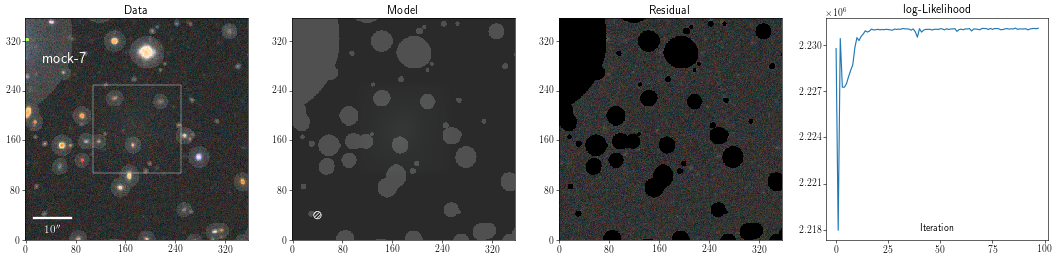

In [481]:
PIL.Image.open('./Figure/mock_sample/mock-7-zoomin-wavelet.png')

In [223]:
fits.open('./Cutout/mock_sample/bkg/mockbkg_1001_r.fits')[1].data.shape

(715, 715)

In [73]:
with open('./mock_measure_log_0_100', 'r') as f:
    text = f.read()

In [74]:
import re

In [75]:
text = text.split('\n')[:-1]

In [77]:
inds = [int(t[re.search('Finish for', t).span()[-1]:].strip()) for t in text]

In [80]:
np.sort(np.array(inds))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [40]:
lsbg = lsbg_cat[12]

In [41]:
import dill

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

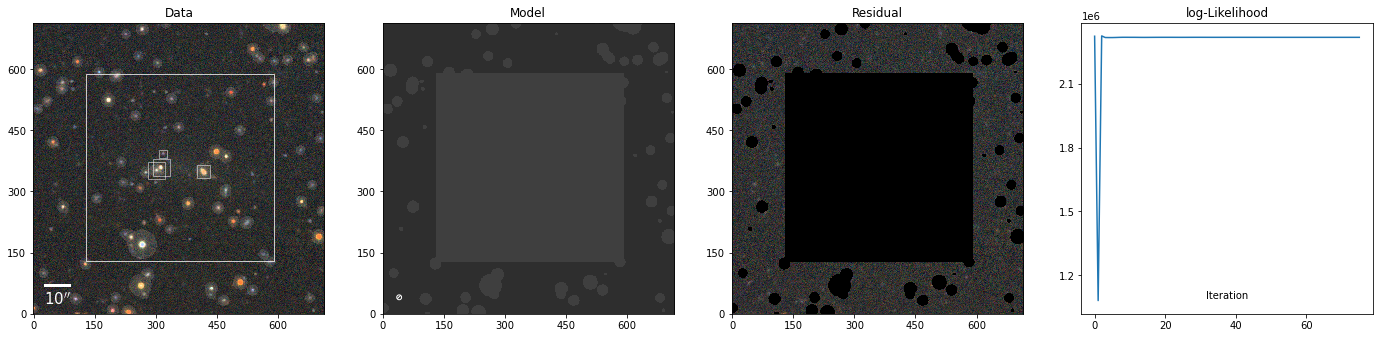

In [42]:
ind = lsbg['viz-id']
method = 'wavelet'
# method = 'vanilla'
with open(f'./Model/mock_sample/{method}/mock-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=True)

In [54]:
cat = Table.read('./Catalog/mock_sample/wavelet/_lsbg_meas_wavelet_monotonic_wavelet_1225_1250_nosegmap.fits')

In [55]:
cat['flux'][:, 0].mask.sum()

6

In [113]:
img, segmap = makeMeasurement(list(np.array(blend.sources)[0:1]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 method='wavelet',
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [121]:
np.sum((img != 0.0) & mask)

84674

In [27]:
measurement, t = makeMeasurement(list(np.array(blend.sources)[0:1]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 method='wavelet',
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
# row = _write_to_row(row, measurement)

Too much masked
